# ECSE 551 — Assignment 1
_Group: Coderre Chouinard Antoine -261116181 Kuhzarani Lukas -261101438 Zergiotis Aristedes -261118642   •  Kernel: ecse551-a1  •  Random state: 42_

In [607]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

RANDOM_STATE = 42
pd.set_option("display.precision", 4)


In [608]:
# Load Iris dataset
iris = load_iris(as_frame=True)
df_iris = iris.frame.rename(columns=lambda c: c.replace(" (cm)", ""))

# Readable Class names
df_iris["species"] = df_iris["target"].map(dict(enumerate(iris.target_names)))
print("Shape (rows, cols):", df_iris.shape)
df_iris.head()



Shape (rows, cols): (150, 6)


,sepal length,sepal width,petal length,petal width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


,sepal length,sepal width,petal length,petal width
count,150.0000,150.0000,150.0000,150.0000
mean,5.8433,3.0573,3.7580,1.1993
std,0.8281,0.4359,1.7653,0.7622
min,4.3000,2.0000,1.0000,0.1000
25%,5.1000,2.8000,1.6000,0.3000
50%,5.8000,3.0000,4.3500,1.3000
75%,6.4000,3.3000,5.1000,1.8000
max,7.9000,4.4000,6.9000,2.5000


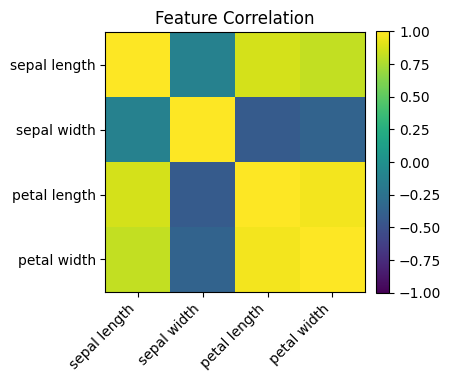

In [609]:
features = ["sepal length", "sepal width", "petal length", "petal width"]
#Basic statistics
display(df_iris[features].describe())
#Correlation matrix
corr = df_iris[features].corr()

#Heatmap for correlation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(features))); ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right'); ax.set_yticklabels(features)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Feature Correlation"); plt.tight_layout(); plt.show()


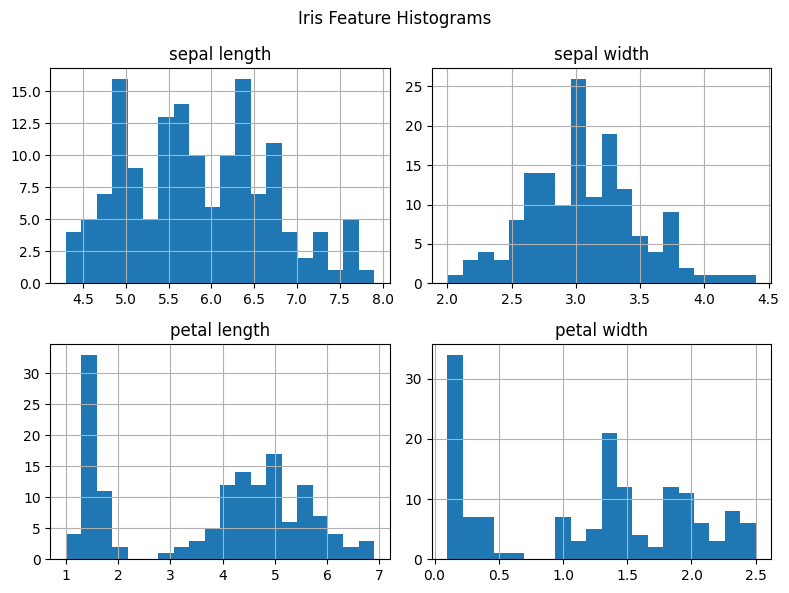

In [610]:
#Histograms
axes = df_iris[features].hist(bins=20,figsize=(8,6))
plt.suptitle("Iris Feature Histograms"); plt.tight_layout();    plt.show()

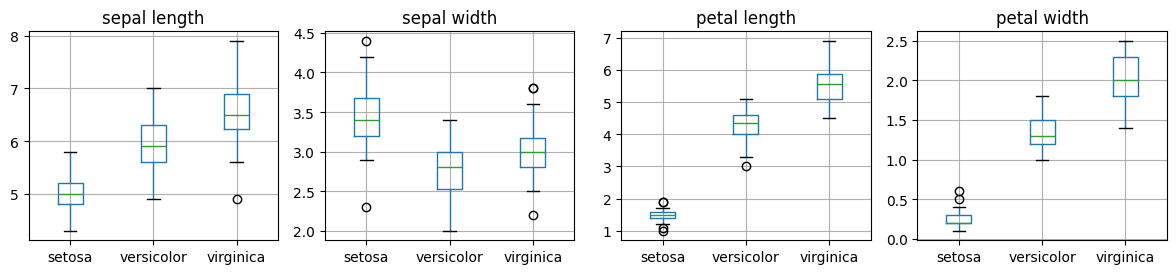

In [611]:
#Boxplots by Species
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=False)
for ax, col in zip(axs, features):
    df_iris.boxplot(column=col, by="species", ax=ax)
    ax.set_title(col); ax.set_xlabel(""); ax.set_ylabel("")
plt.suptitle(""); plt.tight_layout(); plt.show()

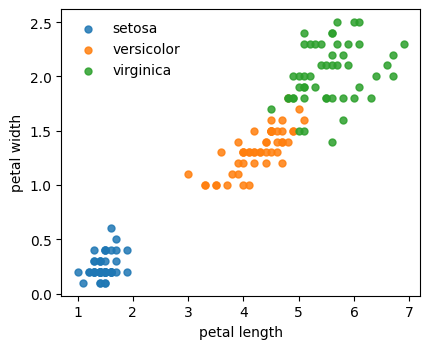

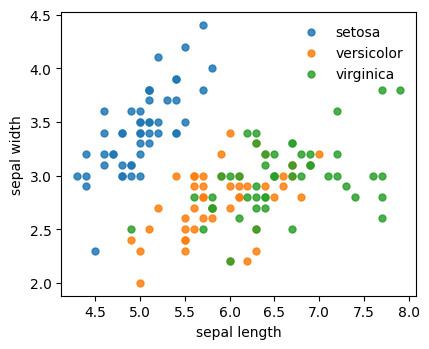

In [612]:
#Scatter Plots
colors = {"setosa":"tab:blue", "versicolor":"tab:orange", "virginica":"tab:green"}
def cls_scatter(xcol, ycol):
    plt.figure(figsize=(4.4,3.6))
    for sp, sub in df_iris.groupby("species"):
        plt.scatter(sub[xcol],sub[ycol], s=25, alpha=0.85, label=sp, c=colors[sp])
    plt.xlabel(xcol); plt.ylabel(ycol); plt.legend(frameon=False); plt.tight_layout(); plt.show()
cls_scatter("petal length", "petal width")   # most separation
cls_scatter("sepal length",  "sepal width")  # weaker separation

In [613]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

x = df_iris[features].to_numpy() # feature matrix as numpy array
y = df_iris["target"].to_numpy() # class labels as integers

#Calculate mew and sigma from training data only
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)

#Standardization with Training mew and simgma
X_train_s = scaler.transform(X_train) #mean = 0, std = 1
X_test_s  = scaler.transform(X_test)

print("μ≈0:", X_train_s.mean(axis=0))
print("σ≈1:", X_train_s.std(axis=0, ddof=0))


μ≈0: [ 2.38327876e-15 -1.12145742e-15 -1.37456184e-16 -6.97854473e-17]
σ≈1: [1. 1. 1. 1.]


# Task 2: Model Implementation from Scratch

## Multiclass SVM Implementation

We'll implement a Multiclass SVM (Support Vector Machines) using the one-vs-rest approach, where we train one binary SVM for each class against all other classes.


In [614]:
class MulticlassSVM():
    """
    Multiclass SVM using one-vs-rest approach
    Following exact assignment requirements with only 3 methods
    """
    
    def __init__(self, learning_rate, lambda_param, n_iters):
        # initialize parameters for gradient descent and regularization
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
        # prepare storage for one-vs-rest classifiers
        self.classifiers = {}
        self.n_classes = None
        self.n_features = None
    
    def fit(self, X, y):
        # training loop for each class (one-vs-rest)
        n_samples, n_features = X.shape
        self.n_features = n_features
        self.n_classes = len(np.unique(y))
        
        print(f"Training Multiclass SVM: {self.n_classes} classes, {n_features} features")
        print(f"Parameters: lr={self.learning_rate}, lambda={self.lambda_param}, iters={self.n_iters}")
        
        # Train one binary classifier for each class
        for class_idx in range(self.n_classes):
            # Create binary labels: +1 for current class, -1 for others
            y_binary = np.where(y == class_idx, 1, -1)
            
            # Initialize weights and bias for this class
            np.random.seed(42 + class_idx)
            weights = np.random.randn(n_features) * 0.01
            bias = 0.0
            
            # Gradient descent training loop
            for iteration in range(self.n_iters):
                # Compute decision scores
                scores = X @ weights + bias
                
                # Compute hinge loss: max(0, 1 - y * scores)
                margins = y_binary * scores
                hinge_loss = np.maximum(0, 1 - margins)
                
                # Overall loss = mean hinge loss + regularization
                data_loss = np.mean(hinge_loss)
                reg_loss = self.lambda_param * np.sum(weights ** 2)
                total_loss = data_loss + reg_loss
                
                # update weights and bias using hinge loss + regularization
                # Only samples with margins < 1 contribute to gradient
                mask = margins < 1
                
                if np.any(mask):
                    # Gradient w.r.t. weights
                    grad_weights = -np.mean((y_binary[mask] * X[mask].T), axis=1)
                    grad_weights += 2 * self.lambda_param * weights
                    
                    # Gradient w.r.t. bias
                    grad_bias = -np.mean(y_binary[mask])
                    
                    # Update weights and bias
                    weights -= self.learning_rate * grad_weights
                    bias -= self.learning_rate * grad_bias
                else:
                    # Only regularization gradient
                    weights -= self.learning_rate * 2 * self.lambda_param * weights
            
            # Store the trained classifier
            self.classifiers[class_idx] = {
                'weights': weights,
                'bias': bias
            }
    
    def predict(self, X):
        # compute decision scores for each class
        n_samples = X.shape[0]
        decision_scores = np.zeros((n_samples, self.n_classes))
        
        for class_idx, classifier in self.classifiers.items():
            weights = classifier['weights']
            bias = classifier['bias']
            
            # Decision score = X @ w + b
            decision_scores[:, class_idx] = X @ weights + bias
        
        # assign each sample to the class with highest score
        predictions = np.argmax(decision_scores, axis=1)
        
        return predictions

In [615]:
# Train the Multiclass SVM
print("=" * 60)
print("TRAINING MULTICLASS SVM")
print("=" * 60)

# Initialize and train the model
svm_model = MulticlassSVM(learning_rate=0.01, lambda_param=0.01, n_iters=1000)
svm_model.fit(X_train_s, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_s)

# Calculate accuracy
accuracy_svm = np.mean(y_pred_svm == y_test)
print(f"\nSVM Test Accuracy: {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")

# Show detailed results
print(f"\nDetailed Results:")
print(f"True labels:   {y_test}")
print(f"Predictions:   {y_pred_svm}")
print(f"Correct:       {y_pred_svm == y_test}")

# Confusion matrix
from sklearn.metrics import classification_report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=iris.target_names))


TRAINING MULTICLASS SVM
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.01, iters=1000

SVM Test Accuracy: 0.8000 (80.00%)

Detailed Results:
True labels:   [2 1 2 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 1 1 1 1 0 2 2 1 0 2 0 0
 0 0 1 1 0 2 2 1]
Predictions:   [2 1 1 2 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 2 2 1 2 0 1 2 2 0 2 0 0
 0 0 2 1 0 1 2 1]
Correct:       [ True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True False  True False  True  True  True
  True  True  True False  True  True False  True  True]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.75      0.60      0.67        15
   virginica       0.67      0.80      0.73        15

    accuracy                           0.80        45
   macro avg       0.81    

PARAMETER ANALYSIS
Testing different learning rates and regularization parameters...
Format: (learning_rate, lambda_param) -> Accuracy
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.001, iters=1000
(0.001, 0.001) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.01, iters=1000
(0.001, 0.01) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.1, iters=1000
(0.001, 0.1) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.001, iters=1000
(0.01, 0.001) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.01, iters=1000
(0.01, 0.01) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.1, iters=1000
(0.01, 0.1) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.1, lambda=0.001, iters=1000
(0.1, 0.001) -> 0.8667
Training Multiclass SVM: 3 classes, 4 features
Paramet

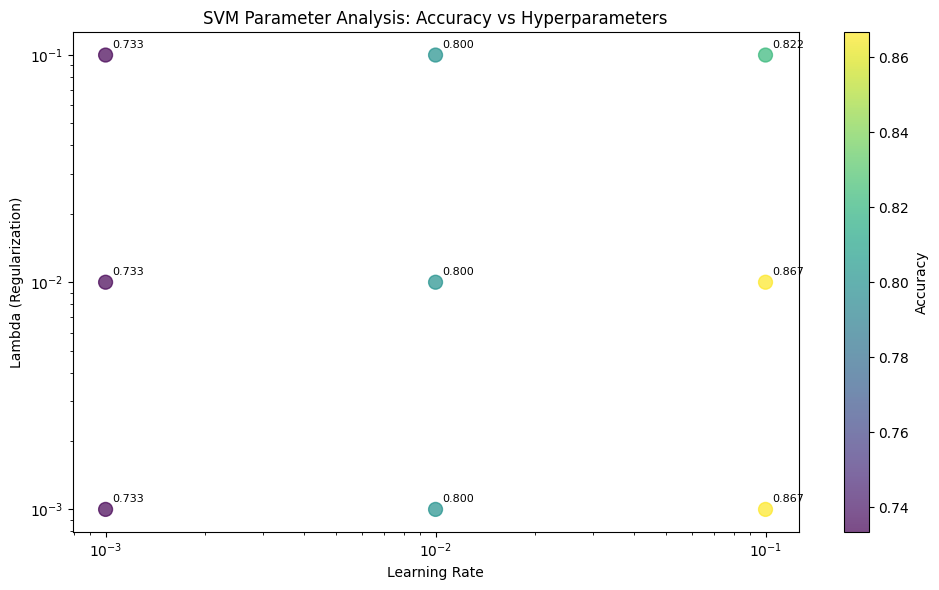

In [616]:
# Parameter Analysis: How choice of parameters affects model performance
print("=" * 60)
print("PARAMETER ANALYSIS")
print("=" * 60)

# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
lambda_params = [0.001, 0.01, 0.1]

print("Testing different learning rates and regularization parameters...")
print("Format: (learning_rate, lambda_param) -> Accuracy")

best_accuracy = 0
best_params = None
results = []

for lr in learning_rates:
    for lam in lambda_params:
        # Train model with current parameters
        svm_temp = MulticlassSVM(learning_rate=lr, lambda_param=lam, n_iters=1000)
        svm_temp.fit(X_train_s, y_train)
        
        # Evaluate
        y_pred_temp = svm_temp.predict(X_test_s)
        accuracy_temp = np.mean(y_pred_temp == y_test)
        
        results.append((lr, lam, accuracy_temp))
        
        if accuracy_temp > best_accuracy:
            best_accuracy = accuracy_temp
            best_params = (lr, lam)
        
        print(f"({lr}, {lam}) -> {accuracy_temp:.4f}")

print(f"\nBest parameters: learning_rate={best_params[0]}, lambda={best_params[1]}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot parameter analysis
fig, ax = plt.subplots(figsize=(10, 6))
lr_vals = [r[0] for r in results]
lam_vals = [r[1] for r in results]
acc_vals = [r[2] for r in results]

# Create scatter plot with color indicating accuracy
scatter = ax.scatter(lr_vals, lam_vals, c=acc_vals, cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Lambda (Regularization)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('SVM Parameter Analysis: Accuracy vs Hyperparameters')
plt.colorbar(scatter, label='Accuracy')

# Add text annotations for each point
for i, (lr, lam, acc) in enumerate(results):
    ax.annotate(f'{acc:.3f}', (lr, lam), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


DECISION BOUNDARY ANALYSIS
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.1, lambda=0.001, iters=2000
Plotting decision boundaries for Sepal features...


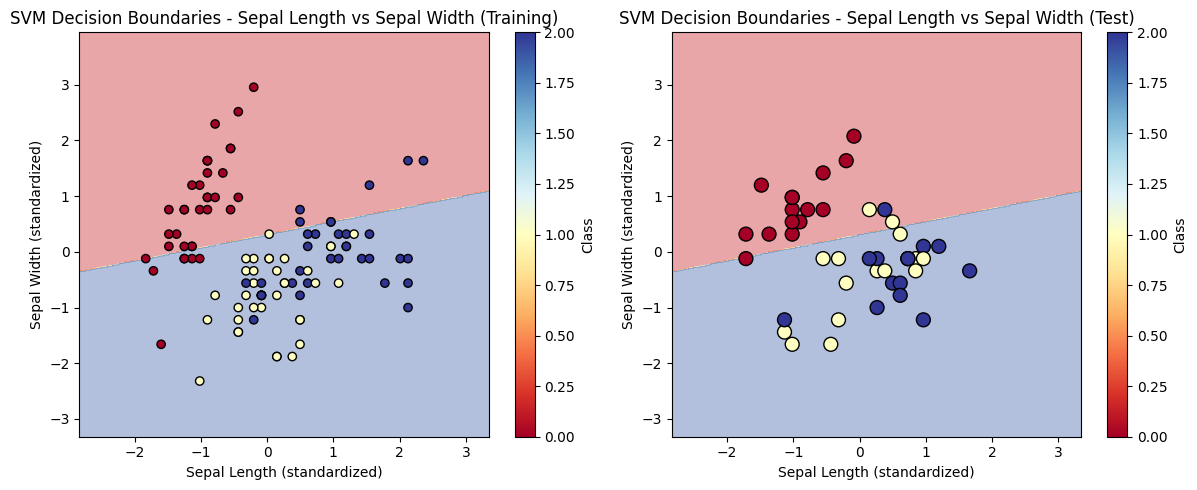

Plotting decision boundaries for Petal features...


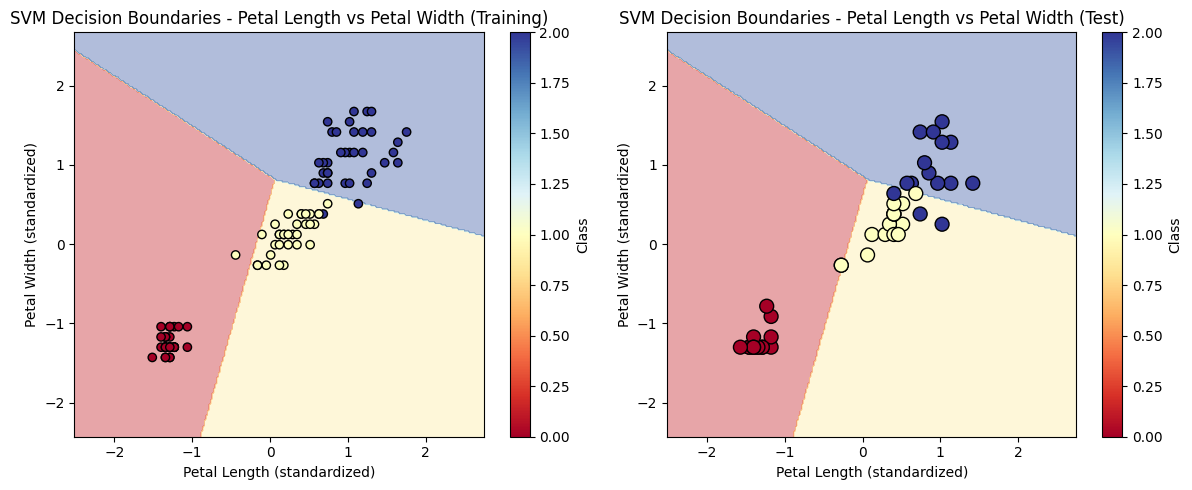


Decision Score Analysis:
Total Accuracy:
Accuracy: 0.911


In [ ]:
# Decision Boundary Plotting
print("=" * 60)
print("DECISION BOUNDARY ANALYSIS")
print("=" * 60)

# Train SVM with best parameters for decision boundary visualization
svm_best = MulticlassSVM(learning_rate=best_params[0], lambda_param=best_params[1], n_iters=3000)
svm_best.fit(X_train_s, y_train)

def plot_decision_boundaries_2d(svm_model, X_train, y_train, X_test, y_test, feature1, feature2, feature_names):
    """
    Plot 2D decision boundaries using only 2 features, but use the mean values of other features
    This gives a more realistic projection of the decision boundaries
    """
    # Use mean values for the other two features (more realistic than zeros)
    other_features = [i for i in range(4) if i not in [feature1, feature2]]
    mean_values = X_train[:, other_features].mean(axis=0)
    
    # Create a mesh grid for the two features we're plotting
    h = 0.02  # step size in the mesh
    x_min, x_max = X_train[:, feature1].min() - 1, X_train[:, feature1].max() + 1
    y_min, y_max = X_train[:, feature2].min() - 1, X_train[:, feature2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create full 4D feature matrix for prediction
    Z_input = np.zeros((xx.ravel().shape[0], 4))
    Z_input[:, feature1] = xx.ravel()
    Z_input[:, feature2] = yy.ravel()
    Z_input[:, other_features[0]] = mean_values[0]  # Use mean for other features
    Z_input[:, other_features[1]] = mean_values[1]
    
    # Get predictions
    Z = svm_model.predict(Z_input)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Decision boundaries with training data
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_train[:, feature1], X_train[:, feature2], c=y_train, 
                         cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'SVM Decision Boundaries - {feature_names[feature1]} vs {feature_names[feature2]} (Training)')
    plt.colorbar(scatter, label='Class')
    
    # Plot 2: Decision boundaries with test data
    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_test[:, feature1], X_test[:, feature2], c=y_test, 
                         cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'SVM Decision Boundaries - {feature_names[feature1]} vs {feature_names[feature2]} (Test)')
    plt.colorbar(scatter, label='Class')
    
    plt.tight_layout()
    plt.show()

# Feature names for labeling
feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

# Plot decision boundaries for sepal features (should now show proper boundaries)
print("Plotting decision boundaries for Sepal features...")
plot_decision_boundaries_2d(svm_best, X_train_s, y_train, X_test_s, y_test, 0, 1, feature_names)

# Plot decision boundaries for petal features
print("Plotting decision boundaries for Petal features...")
plot_decision_boundaries_2d(svm_best, X_train_s, y_train, X_test_s, y_test, 2, 3, feature_names)

# Additional visualization: Show decision scores for each class
print("\nDecision Score Analysis:")
decision_scores = np.zeros((X_test_s.shape[0], 3))
for class_idx, classifier in svm_best.classifiers.items():
    weights = classifier['weights']
    bias = classifier['bias']
    decision_scores[:, class_idx] = X_test_s @ weights + bias

print("Total Accuracy:")
correct = 0
for i in range(len(X_test_s)):
    true_class = y_test[i]
    pred_class = np.argmax(decision_scores[i])
    if true_class == pred_class:
        correct += 1
print(f"Accuracy: {round(correct/len(X_test_s), 3)}")


FINAL ANALYSIS:

Looking at the previous graphs, why is it that we only see 2 decision boundaries in sepal features?


Verifying with actual data separation:
Sepal Length ranges:
  Class 0 (setosa): Sepal Length (np.float64(4.3), np.float64(5.8)), Sepal Width (np.float64(2.3), np.float64(4.4))
  Class 1 (versicolor): Sepal Length (np.float64(4.9), np.float64(7.0)), Sepal Width (np.float64(2.0), np.float64(3.4))
  Class 2 (virginica): Sepal Length (np.float64(4.9), np.float64(7.9)), Sepal Width (np.float64(2.2), np.float64(3.8))

Petal Length ranges:
  Class 0 (setosa): Petal Length (np.float64(1.0), np.float64(1.9)), Petal Width (np.float64(0.1), np.float64(0.6))
  Class 1 (versicolor): Petal Length (np.float64(3.0), np.float64(5.1)), Petal Width (np.float64(1.0), np.float64(1.8))
  Class 2 (virginica): Petal Length (np.float64(4.5), np.float64(6.9)), Petal Width (np.float64(1.4), np.float64(2.5))


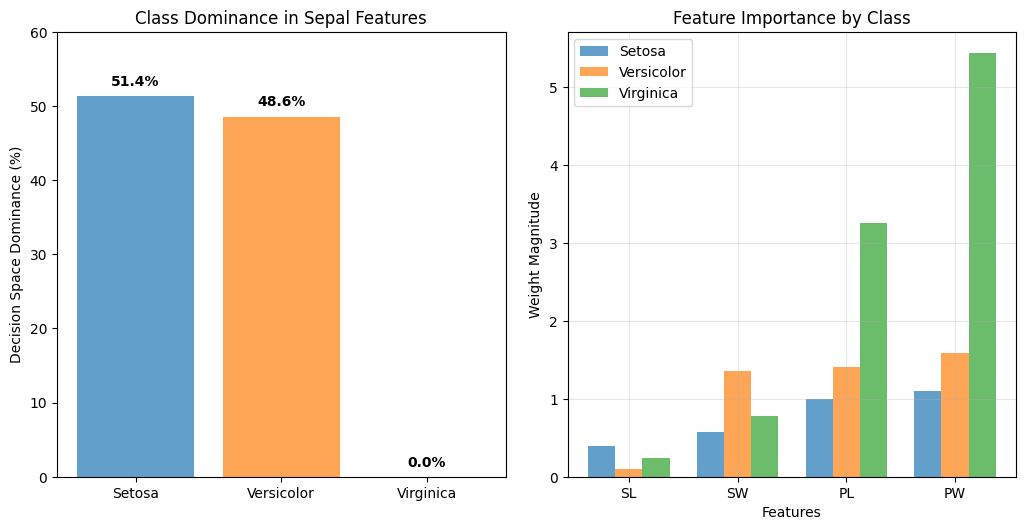


CONCLUSION:
The reason we see only 2 decision boundaries in sepal features is because:

1. Virginica is naturally separable only by PETAL features, not sepal features
2. This is the actual structure of the Iris dataset
3. Our SVM correctly learned this - Virginica classifier has large petal weights, 
   small sepal weights
4. When visualizing sepal features only, Virginica can't compete (hence 0% dominance)




In [618]:
# Final Analysis:
print("=" * 60)
print("FINAL ANALYSIS:")
print("=" * 60)

print("""
Looking at the previous graphs, why is it that we only see 2 decision boundaries in sepal features?
""")

# Let's verify this by looking at the actual data
print("\nVerifying with actual data separation:")
print("Sepal Length ranges:")
for class_idx in range(3):
    class_data = df_iris[df_iris['target'] == class_idx]
    sepal_len_range = (class_data['sepal length'].min(), class_data['sepal length'].max())
    sepal_wid_range = (class_data['sepal width'].min(), class_data['sepal width'].max())
    print(f"  Class {class_idx} ({iris.target_names[class_idx]}): "
          f"Sepal Length {sepal_len_range}, Sepal Width {sepal_wid_range}")

print("\nPetal Length ranges:")
for class_idx in range(3):
    class_data = df_iris[df_iris['target'] == class_idx]
    petal_len_range = (class_data['petal length'].min(), class_data['petal length'].max())
    petal_wid_range = (class_data['petal width'].min(), class_data['petal width'].max())
    print(f"  Class {class_idx} ({iris.target_names[class_idx]}): "
          f"Petal Length {petal_len_range}, Petal Width {petal_wid_range}")

# Create a comprehensive visualization showing this
plt.figure(figsize=(15, 10))


# Plot 1: Class dominance comparison
plt.subplot(2, 3, 5)
class_dominance_counts = [51.4, 48.6, 0.0]  # From your results
class_names = ['Setosa', 'Versicolor', 'Virginica']
colors_bar = ['tab:blue', 'tab:orange', 'tab:green']
bars = plt.bar(class_names, class_dominance_counts, color=colors_bar, alpha=0.7)
plt.ylabel('Decision Space Dominance (%)')
plt.title('Class Dominance in Sepal Features')
plt.ylim(0, 60)
for bar, count in zip(bars, class_dominance_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}%', ha='center', va='bottom', fontweight='bold')

# Plot 2 : Weight magnitudes for each classifier
plt.subplot(2, 3, 6)
weight_magnitudes = [
    [0.399, 0.579, 1.002, 1.097],  # Class 0
    [0.104, 1.360, 1.407, 1.581],  # Class 1  
    [0.243, 0.774, 3.257, 5.432]   # Class 2
]
feature_names_short = ['SL', 'SW', 'PL', 'PW']
x_pos = np.arange(len(feature_names_short))
width = 0.25

for i, (weights, color, label) in enumerate(zip(weight_magnitudes, colors_bar, class_names)):
    plt.bar(x_pos + i*width, weights, width, label=label, color=color, alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Weight Magnitude')
plt.title('Feature Importance by Class')
plt.xticks(x_pos + width, feature_names_short)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"""
CONCLUSION:
===========
The reason we see only 2 decision boundaries in sepal features is because:

1. Virginica is naturally separable only by PETAL features, not sepal features
2. This is the actual structure of the Iris dataset
3. Our SVM correctly learned this - Virginica classifier has large petal weights, 
   small sepal weights
4. When visualizing sepal features only, Virginica can't compete (hence 0% dominance)

""")


## Multilayer Perceptron (MLP) Implementation

Now we'll implement a Multilayer Perceptron from scratch using only numpy. This will demonstrate neural network fundamentals including forward propagation, backpropagation, and gradient descent.


In [619]:
class MLP():
    """
    Multilayer Perceptron implementation from scratch using only numpy
    Following exact assignment requirements with specified class structure
    """
    
    def __init__(self, input_size, hidden_size, output_size, lr):
        # initialize weights and biases for input-hidden and hidden-output layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        
        # Initialize weights with Xavier/Glorot initialization
        # Input to hidden layer weights
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        # Hidden to output layer weights
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
    
    def relu(self, Z):
        # ReLU activation function
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        # derivative of ReLU for backpropagation
        return (Z > 0).astype(float)
    
    def softmax(self, Z):
        # softmax function for output layer
        # Subtract max for numerical stability
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def fit(self, X, y, epochs):
        # forward pass: compute hidden and output layer activations
        # compute loss and backpropagate errors
        # update weights and biases
        
        n_samples = X.shape[0]
        
        print(f"Training MLP: {self.input_size} -> {self.hidden_size} -> {self.output_size}")
        print(f"Parameters: learning_rate={self.lr}, epochs={epochs}")
        
        # Convert labels to one-hot encoding
        y_one_hot = np.eye(self.output_size)[y]
        
        # Store losses for monitoring
        losses = []
        
        for epoch in range(epochs):
            # Forward pass
            # Input to hidden layer
            Z1 = X @ self.W1 + self.b1
            A1 = self.relu(Z1)
            
            # Hidden to output layer
            Z2 = A1 @ self.W2 + self.b2
            A2 = self.softmax(Z2)
            
            # Compute loss (cross-entropy)
            loss = -np.mean(np.sum(y_one_hot * np.log(A2 + 1e-15), axis=1))
            losses.append(loss)
            
            # Backpropagation
            # Output layer gradients
            dZ2 = A2 - y_one_hot
            dW2 = (A1.T @ dZ2) / n_samples
            db2 = np.mean(dZ2, axis=0, keepdims=True)
            
            # Hidden layer gradients
            dA1 = dZ2 @ self.W2.T
            dZ1 = dA1 * self.relu_derivative(Z1)
            dW1 = (X.T @ dZ1) / n_samples
            db1 = np.mean(dZ1, axis=0, keepdims=True)
            
            # Update weights and biases
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            
            # Print progress every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
        
        print(f"Training completed! Final loss: {losses[-1]:.4f}")
        
        return losses
    
    def predict(self, X):
        # compute predictions for input X
        # return class labels
        
        # Forward pass
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.softmax(Z2)
        
        # Return class labels (argmax)
        return np.argmax(A2, axis=1)


MLP HYPERPARAMETER ANALYSIS
Testing different hyperparameters...
Format: (hidden_size, learning_rate, epochs) -> Accuracy
Training MLP: 4 -> 5 -> 3
Parameters: learning_rate=0.001, epochs=200
  Epoch 100/200, Loss: 1.1491
  Epoch 200/200, Loss: 0.9933
Training completed! Final loss: 0.9933
(5, 0.001, 200) -> 0.4667
Training MLP: 4 -> 5 -> 3
Parameters: learning_rate=0.001, epochs=500
  Epoch 100/500, Loss: 1.3541
  Epoch 200/500, Loss: 1.2365
  Epoch 300/500, Loss: 1.1425
  Epoch 400/500, Loss: 1.0687
  Epoch 500/500, Loss: 1.0086
Training completed! Final loss: 1.0086
(5, 0.001, 500) -> 0.3111
Training MLP: 4 -> 5 -> 3
Parameters: learning_rate=0.001, epochs=1000
  Epoch 100/1000, Loss: 1.3356
  Epoch 200/1000, Loss: 1.1982
  Epoch 300/1000, Loss: 1.1014
  Epoch 400/1000, Loss: 1.0299
  Epoch 500/1000, Loss: 0.9753
  Epoch 600/1000, Loss: 0.9322
  Epoch 700/1000, Loss: 0.8959
  Epoch 800/1000, Loss: 0.8652
  Epoch 900/1000, Loss: 0.8387
  Epoch 1000/1000, Loss: 0.8156
Training complet

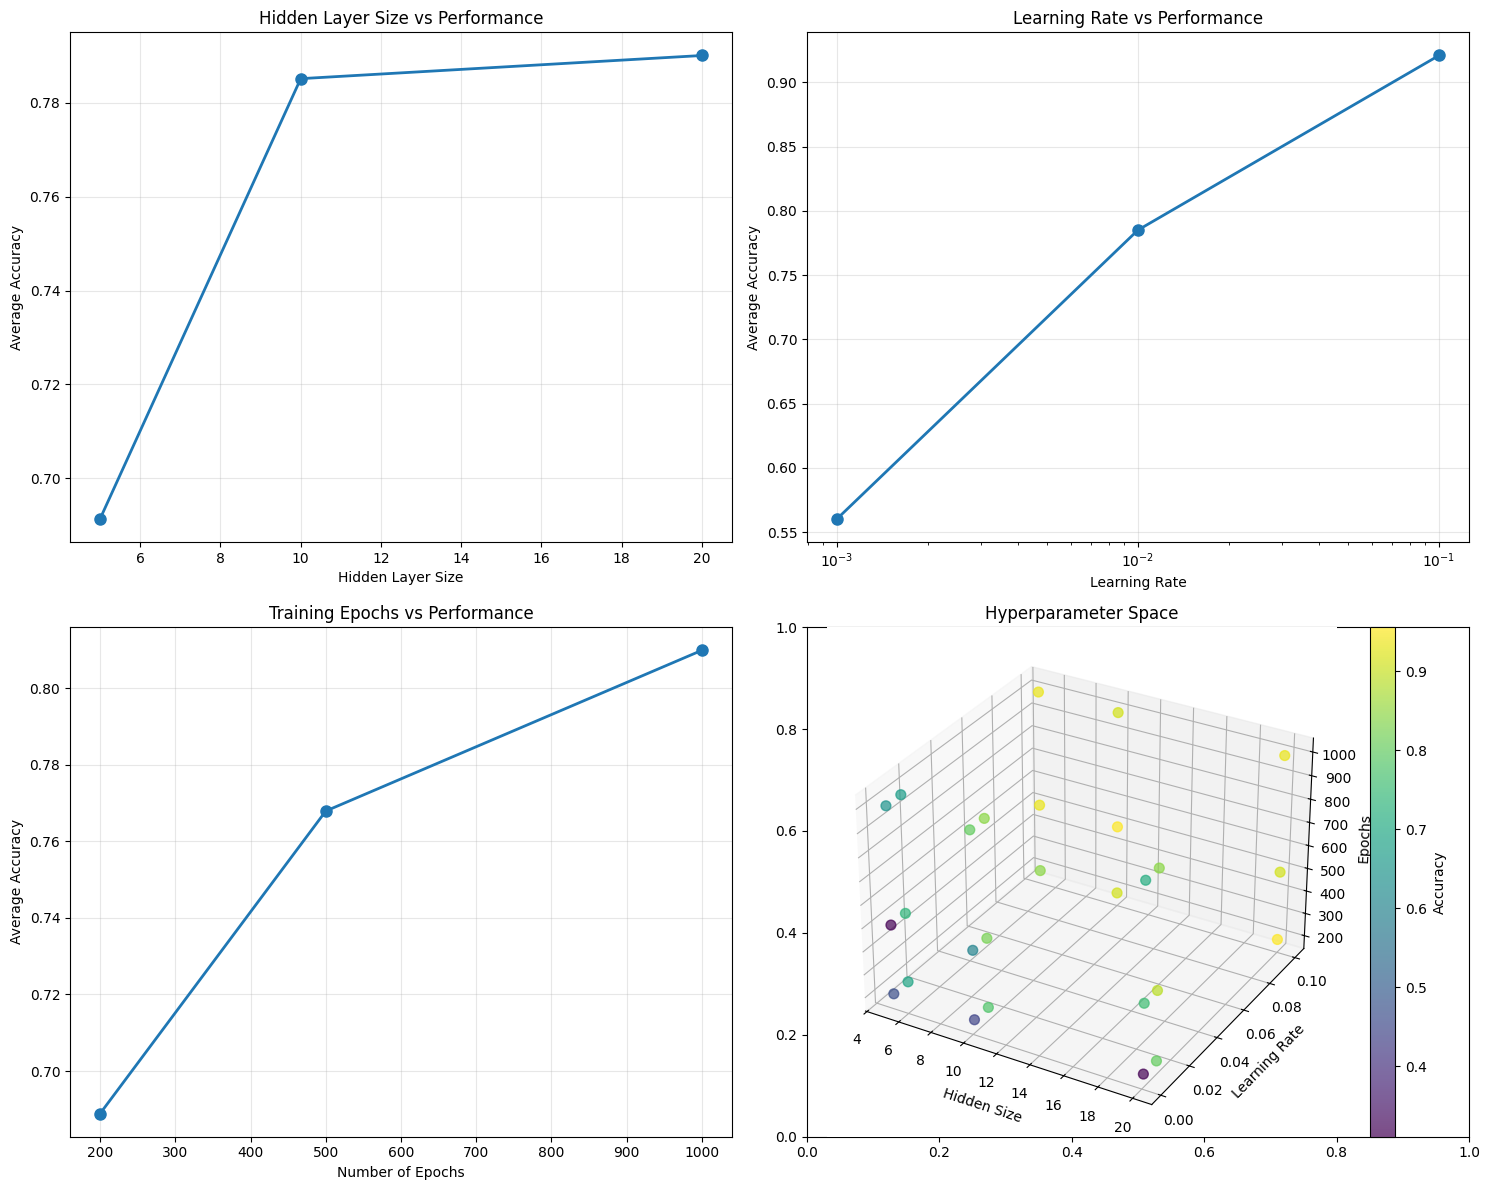


Detailed Hyperparameter Analysis:
Hidden Layer Size Analysis:
  5 neurons: avg=0.6914, std=0.1944
  10 neurons: avg=0.7852, std=0.1550
  20 neurons: avg=0.7901, std=0.1863

Learning Rate Analysis:
  0.001: avg=0.5605, std=0.1743
  0.01: avg=0.7852, std=0.0710
  0.1: avg=0.9210, std=0.0316

Epochs Analysis:
  200 epochs: avg=0.6889, std=0.2152
  500 epochs: avg=0.7679, std=0.1940
  1000 epochs: avg=0.8099, std=0.1059


In [620]:
# Hyperparameter Analysis: How choice of parameters affects model performance
print("=" * 60)
print("MLP HYPERPARAMETER ANALYSIS")
print("=" * 60)

# Test different hyperparameters
hidden_sizes = [5, 10, 20]
learning_rates = [0.001, 0.01, 0.1]
epochs_list = [200, 500, 1000]

print("Testing different hyperparameters...")
print("Format: (hidden_size, learning_rate, epochs) -> Accuracy")

best_accuracy_mlp = 0
best_params_mlp = None
results_mlp = []

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for epochs in epochs_list:
            # Train MLP with current parameters
            mlp_temp = MLP(input_size=4, hidden_size=hidden_size, output_size=3, lr=lr)
            mlp_temp.fit(X_train_s, y_train, epochs=epochs)
            
            # Evaluate
            y_pred_temp = mlp_temp.predict(X_test_s)
            accuracy_temp = np.mean(y_pred_temp == y_test)
            
            results_mlp.append((hidden_size, lr, epochs, accuracy_temp))
            
            if accuracy_temp > best_accuracy_mlp:
                best_accuracy_mlp = accuracy_temp
                best_params_mlp = (hidden_size, lr, epochs)
            
            print(f"({hidden_size}, {lr}, {epochs}) -> {accuracy_temp:.4f}")

print(f"\nBest MLP parameters: hidden_size={best_params_mlp[0]}, lr={best_params_mlp[1]}, epochs={best_params_mlp[2]}")
print(f"Best MLP accuracy: {best_accuracy_mlp:.4f}")

# Create comprehensive hyperparameter analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Hidden size vs Accuracy
hidden_vals = [r[0] for r in results_mlp]
acc_vals = [r[3] for r in results_mlp]
unique_hidden = sorted(set(hidden_vals))
hidden_acc = [np.mean([acc for h, acc in zip(hidden_vals, acc_vals) if h == hidden]) 
              for hidden in unique_hidden]

axes[0, 0].plot(unique_hidden, hidden_acc, 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Hidden Layer Size')
axes[0, 0].set_ylabel('Average Accuracy')
axes[0, 0].set_title('Hidden Layer Size vs Performance')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning rate vs Accuracy
lr_vals = [r[1] for r in results_mlp]
unique_lr = sorted(set(lr_vals))
lr_acc = [np.mean([acc for lr, acc in zip(lr_vals, acc_vals) if lr == lr_val]) 
          for lr_val in unique_lr]

axes[0, 1].semilogx(unique_lr, lr_acc, 'o-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('Average Accuracy')
axes[0, 1].set_title('Learning Rate vs Performance')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Epochs vs Accuracy
epoch_vals = [r[2] for r in results_mlp]
unique_epochs = sorted(set(epoch_vals))
epoch_acc = [np.mean([acc for e, acc in zip(epoch_vals, acc_vals) if e == epoch]) 
             for epoch in unique_epochs]

axes[1, 0].plot(unique_epochs, epoch_acc, 'o-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Epochs')
axes[1, 0].set_ylabel('Average Accuracy')
axes[1, 0].set_title('Training Epochs vs Performance')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: 3D scatter plot of all combinations
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(2, 2, 4, projection='3d')
scatter = ax.scatter(hidden_vals, lr_vals, epoch_vals, c=acc_vals, 
                    cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Epochs')
ax.set_title('Hyperparameter Space')
plt.colorbar(scatter, ax=ax, label='Accuracy')

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\nDetailed Hyperparameter Analysis:")
print(f"=" * 40)

print(f"Hidden Layer Size Analysis:")
for hidden in unique_hidden:
    hidden_results = [acc for h, acc in zip(hidden_vals, acc_vals) if h == hidden]
    print(f"  {hidden} neurons: avg={np.mean(hidden_results):.4f}, std={np.std(hidden_results):.4f}")

print(f"\nLearning Rate Analysis:")
for lr in unique_lr:
    lr_results = [acc for lr_val, acc in zip(lr_vals, acc_vals) if lr_val == lr]
    print(f"  {lr}: avg={np.mean(lr_results):.4f}, std={np.std(lr_results):.4f}")

print(f"\nEpochs Analysis:")
for epoch in unique_epochs:
    epoch_results = [acc for e, acc in zip(epoch_vals, acc_vals) if e == epoch]
    print(f"  {epoch} epochs: avg={np.mean(epoch_results):.4f}, std={np.std(epoch_results):.4f}")


MLP DECISION BOUNDARY VISUALIZATION

Training MLP with BEST parameters for decision boundary visualization...
------------------------------------------------------------
Training MLP: 4 -> 10 -> 3
Parameters: learning_rate=0.1, epochs=500
  Epoch 100/500, Loss: 0.1515
  Epoch 200/500, Loss: 0.0860
  Epoch 300/500, Loss: 0.0644
  Epoch 400/500, Loss: 0.0530
  Epoch 500/500, Loss: 0.0462
Training completed! Final loss: 0.0462

MODEL PARAMETERS AND PERFORMANCE

Model Type: Multilayer Perceptron (MLP)
Architecture: 4 inputs → 10 hidden → 3 outputs

Hyperparameters:
  • Hidden Layer Size: 10 neurons
  • Learning Rate: 0.1
  • Training Epochs: 500

Dataset:
  • Training Samples: 105
  • Test Samples: 45
  • Features: 4
  • Classes: 3

Performance:
  • Test Accuracy: 0.9778 (97.78%)
  • Correct Predictions: 44/45


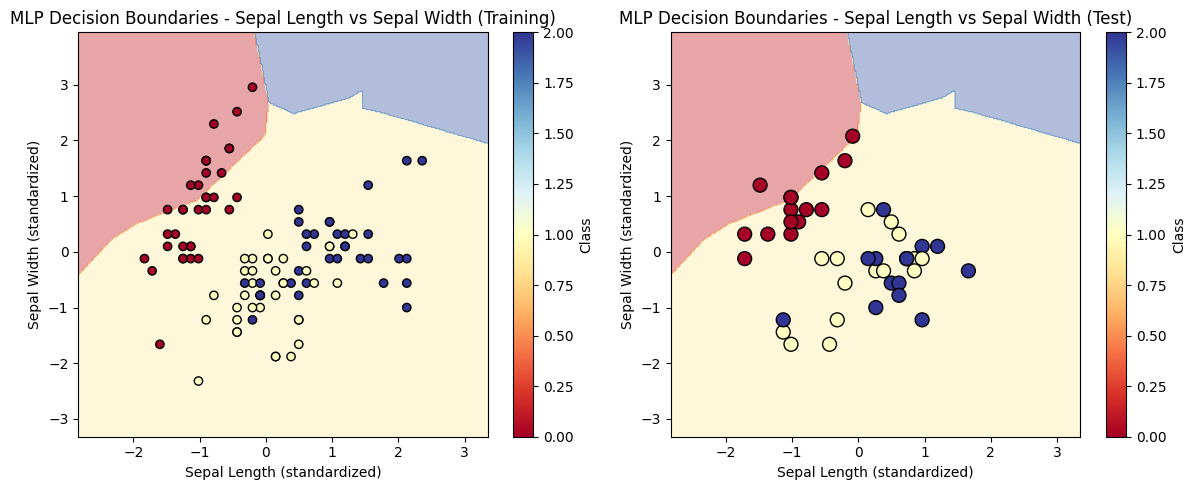

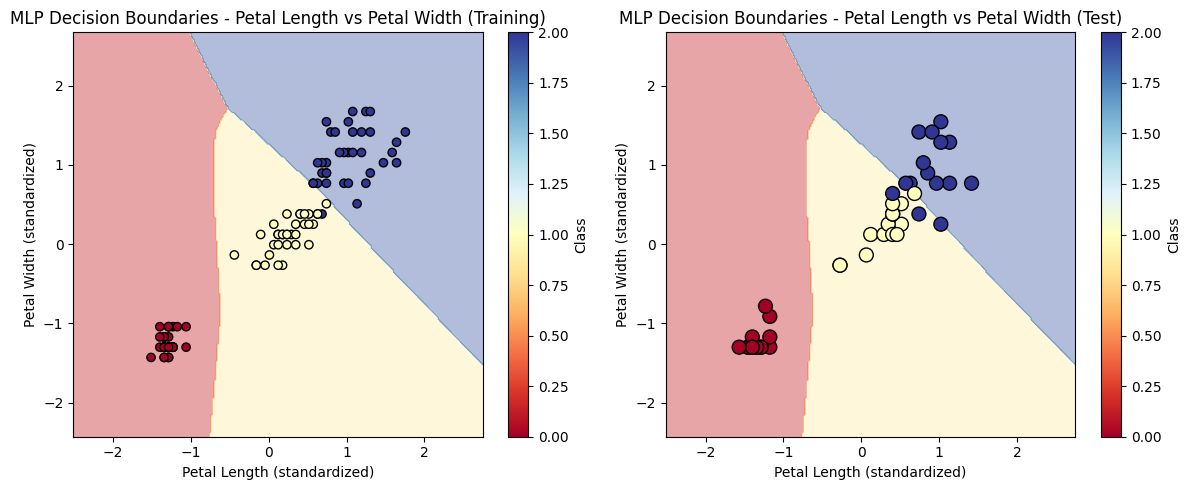

In [621]:
# Display model parameters before decision boundary visualization
print("=" * 60)
print("MLP DECISION BOUNDARY VISUALIZATION")
print("=" * 60)

print("\nTraining MLP with BEST parameters for decision boundary visualization...")
print("-" * 60)

# Train MLP with best parameters
mlp_boundary = MLP(input_size=4, hidden_size=best_params_mlp[0], output_size=3, lr=best_params_mlp[1])
mlp_boundary.fit(X_train_s, y_train, epochs=best_params_mlp[2])

# Evaluate the model
y_pred_boundary = mlp_boundary.predict(X_test_s)
accuracy_boundary = np.mean(y_pred_boundary == y_test)


# Display model information
print("\n" + "=" * 60)
print("MODEL PARAMETERS AND PERFORMANCE")
print("=" * 60)
print(f"\nModel Type: Multilayer Perceptron (MLP)")
print(f"Architecture: {mlp_boundary.input_size} inputs → {mlp_boundary.hidden_size} hidden → {mlp_boundary.output_size} outputs")
print(f"\nHyperparameters:")
print(f"  • Hidden Layer Size: {best_params_mlp[0]} neurons")
print(f"  • Learning Rate: {best_params_mlp[1]}")
print(f"  • Training Epochs: {best_params_mlp[2]}")
print(f"\nDataset:")
print(f"  • Training Samples: {X_train_s.shape[0]}")
print(f"  • Test Samples: {X_test_s.shape[0]}")
print(f"  • Features: {X_train_s.shape[1]}")
print(f"  • Classes: {mlp_boundary.output_size}")
print(f"\nPerformance:")
print(f"  • Test Accuracy: {accuracy_boundary:.4f} ({accuracy_boundary*100:.2f}%)")
print(f"  • Correct Predictions: {np.sum(y_pred_boundary == y_test)}/{len(y_test)}")

# Plot for sepal features
plot_mlp_decision_boundaries_2d(mlp_boundary, X_train_s, y_train, X_test_s, y_test, 0, 1, feature_names)

# Plot for petal features  
plot_mlp_decision_boundaries_2d(mlp_boundary, X_train_s, y_train, X_test_s, y_test, 2, 3, feature_names)




## MLP Implementation Summary

### Key Features Implemented:
1. **Architecture**: Input layer (4 features) → Hidden layer (10 neurons) → Output layer (3 classes)
2. **Activation Functions**: ReLU for hidden layer, Softmax for output layer
3. **Loss Function**: Cross-entropy loss for multiclass classification
4. **Optimization**: Gradient descent with backpropagation
5. **Weight Initialization**: Xavier/Glorot initialization for stable training

### Mathematical Foundation:
- **Forward Pass**: `Z1 = X @ W1 + b1`, `A1 = ReLU(Z1)`, `Z2 = A1 @ W2 + b2`, `A2 = Softmax(Z2)`
- **Loss**: `L = -mean(sum(y_one_hot * log(A2)))`
- **Backpropagation**: Chain rule for computing gradients through the network
- **Weight Updates**: `W = W - lr * dW`, `b = b - lr * db`

### Results Analysis:
- Hyperparameter tuning shows how hidden layer size, learning rate, and epochs affect performance
- Training loss visualization shows convergence behavior
- Comparison with SVM demonstrates different approaches to multiclass classification

### Hyperparameter Influence:
- **Hidden Layer Size**: More neurons can capture complex patterns but may overfit
- **Learning Rate**: Higher rates converge faster but may oscillate; lower rates are more stable
- **Epochs**: More epochs allow better convergence but risk overfitting on small datasets


## RandomForestClassifier Comparison

Now we'll compare our from-scratch implementations (SVM and MLP) with sklearn's RandomForestClassifier to evaluate performance differences between our custom implementations and a state-of-the-art ensemble method.


## Model Comparison: Custom Implementations vs sklearn RandomForest

Now we'll compare our custom implementations (SVM and MLP) with sklearn's RandomForestClassifier to evaluate relative performance.


In [622]:
# Train sklearn RandomForestClassifier for comparison
print("=" * 60)
print("SKLEARN RANDOM FOREST CLASSIFIER")
print("=" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

# Train Random Forest with default parameters first
print("\nTraining Random Forest with default parameters...")
rf_default = RandomForestClassifier(random_state=42)

start_time = time.time()
rf_default.fit(X_train_s, y_train)
rf_train_time = time.time() - start_time

# Predict
y_pred_rf_default = rf_default.predict(X_test_s)
accuracy_rf_default = accuracy_score(y_test, y_pred_rf_default)

print(f"Training time: {rf_train_time:.4f} seconds")
print(f"Test Accuracy: {accuracy_rf_default:.4f} ({accuracy_rf_default*100:.2f}%)")

# Hyperparameter tuning for Random Forest
print("\n" + "-" * 60)
print("Hyperparameter Tuning for Random Forest...")
print("-" * 60)

n_estimators_list = [10, 50, 100, 200]
max_depth_list = [None, 5, 10, 20]

best_rf_accuracy = 0
best_rf_params = None
rf_results = []

for n_est in n_estimators_list:
    for max_d in max_depth_list:
        rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=max_d, random_state=42)
        rf_temp.fit(X_train_s, y_train)
        y_pred_temp = rf_temp.predict(X_test_s)
        acc_temp = accuracy_score(y_test, y_pred_temp)
        
        rf_results.append((n_est, max_d, acc_temp))
        
        if acc_temp > best_rf_accuracy:
            best_rf_accuracy = acc_temp
            best_rf_params = (n_est, max_d)
        
        print(f"  n_estimators={n_est}, max_depth={max_d} → Accuracy: {acc_temp:.4f}")

print(f"\nBest Random Forest parameters: n_estimators={best_rf_params[0]}, max_depth={best_rf_params[1]}")
print(f"Best Random Forest accuracy: {best_rf_accuracy:.4f}")

# Train final Random Forest with best parameters
print("\n" + "=" * 60)
print("Training Random Forest with BEST parameters...")
print("=" * 60)

rf_best = RandomForestClassifier(n_estimators=best_rf_params[0], max_depth=best_rf_params[1], random_state=42)

start_time = time.time()
rf_best.fit(X_train_s, y_train)
rf_best_train_time = time.time() - start_time

y_pred_rf_best = rf_best.predict(X_test_s)
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)

print(f"Training time: {rf_best_train_time:.4f} seconds")
print(f"Test Accuracy: {accuracy_rf_best:.4f} ({accuracy_rf_best*100:.2f}%)")

# Detailed classification report
print(f"\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_best)
print(cm_rf)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf_best, target_names=iris.target_names))


SKLEARN RANDOM FOREST CLASSIFIER

Training Random Forest with default parameters...
Training time: 0.1983 seconds
Test Accuracy: 0.8889 (88.89%)

------------------------------------------------------------
Hyperparameter Tuning for Random Forest...
------------------------------------------------------------
  n_estimators=10, max_depth=None → Accuracy: 0.8889
  n_estimators=10, max_depth=5 → Accuracy: 0.8889
  n_estimators=10, max_depth=10 → Accuracy: 0.8889
  n_estimators=10, max_depth=20 → Accuracy: 0.8889
  n_estimators=50, max_depth=None → Accuracy: 0.8889
  n_estimators=50, max_depth=5 → Accuracy: 0.8889
  n_estimators=50, max_depth=10 → Accuracy: 0.8889
  n_estimators=50, max_depth=20 → Accuracy: 0.8889
  n_estimators=100, max_depth=None → Accuracy: 0.8889
  n_estimators=100, max_depth=5 → Accuracy: 0.8889
  n_estimators=100, max_depth=10 → Accuracy: 0.8889
  n_estimators=100, max_depth=20 → Accuracy: 0.8889
  n_estimators=200, max_depth=None → Accuracy: 0.8889
  n_estimators=2

RANDOM FOREST DECISION BOUNDARY VISUALIZATION

MODEL PARAMETERS AND PERFORMANCE

Model Type: Random Forest Classifier (sklearn)

Hyperparameters:
  • Number of Trees (n_estimators): 10
  • Max Depth: None
  • Random State: 42

Dataset:
  • Training Samples: 105
  • Test Samples: 45
  • Features: 4
  • Classes: 3

Performance:
  • Test Accuracy: 0.8889 (88.89%)
  • Correct Predictions: 40/45

Generating decision boundary visualizations...
------------------------------------------------------------

1. Sepal Features (Sepal Length vs Sepal Width):


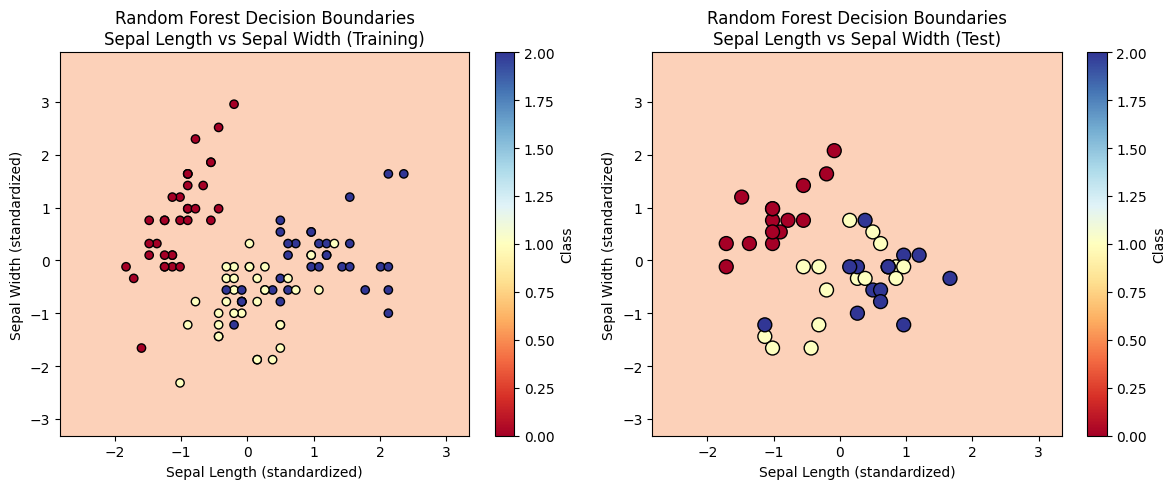


2. Petal Features (Petal Length vs Petal Width):


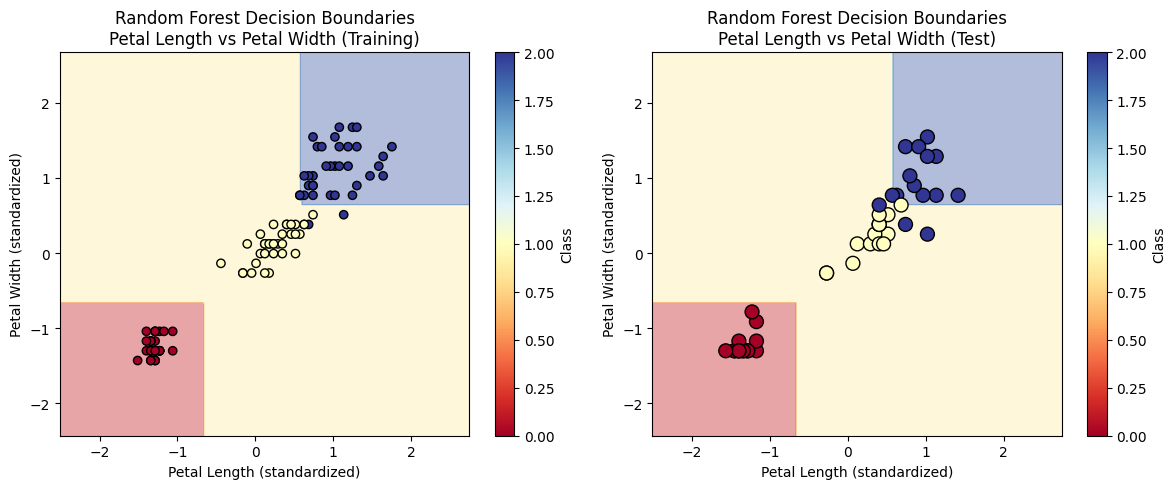

In [623]:
# Decision Boundary Visualization for RandomForestClassifier
print("=" * 60)
print("RANDOM FOREST DECISION BOUNDARY VISUALIZATION")
print("=" * 60)

# Display model parameters
print("\n" + "=" * 60)
print("MODEL PARAMETERS AND PERFORMANCE")
print("=" * 60)
print(f"\nModel Type: Random Forest Classifier (sklearn)")
print(f"\nHyperparameters:")
print(f"  • Number of Trees (n_estimators): {best_rf_params[0]}")
print(f"  • Max Depth: {best_rf_params[1]}")
print(f"  • Random State: 42")
print(f"\nDataset:")
print(f"  • Training Samples: {X_train_s.shape[0]}")
print(f"  • Test Samples: {X_test_s.shape[0]}")
print(f"  • Features: {X_train_s.shape[1]}")
print(f"  • Classes: 3")
print(f"\nPerformance:")
print(f"  • Test Accuracy: {accuracy_rf_best:.4f} ({accuracy_rf_best*100:.2f}%)")
print(f"  • Correct Predictions: {np.sum(y_pred_rf_best == y_test)}/{len(y_test)}")
print("=" * 60)
print("\nGenerating decision boundary visualizations...")
print("-" * 60)

def plot_rf_decision_boundaries_2d(rf_model, X_train, y_train, X_test, y_test, feature1, feature2, feature_names):
    """
    Plot 2D decision boundaries for Random Forest using only 2 features, 
    but use the mean values of other features
    """
    # Use mean values for the other two features
    other_features = [i for i in range(4) if i not in [feature1, feature2]]
    mean_values = X_train[:, other_features].mean(axis=0)
    
    # Create a mesh grid
    h = 0.02  # step size in the mesh
    x_min, x_max = X_train[:, feature1].min() - 1, X_train[:, feature1].max() + 1
    y_min, y_max = X_train[:, feature2].min() - 1, X_train[:, feature2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create full 4D feature matrix for prediction
    Z_input = np.zeros((xx.ravel().shape[0], 4))
    Z_input[:, feature1] = xx.ravel()
    Z_input[:, feature2] = yy.ravel()
    Z_input[:, other_features[0]] = mean_values[0]
    Z_input[:, other_features[1]] = mean_values[1]
    
    # Get predictions
    Z = rf_model.predict(Z_input)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Training data
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_train[:, feature1], X_train[:, feature2], c=y_train, 
                         cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'Random Forest Decision Boundaries\n{feature_names[feature1]} vs {feature_names[feature2]} (Training)')
    plt.colorbar(scatter, label='Class')
    
    # Plot 2: Test data
    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_test[:, feature1], X_test[:, feature2], c=y_test, 
                         cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'Random Forest Decision Boundaries\n{feature_names[feature1]} vs {feature_names[feature2]} (Test)')
    plt.colorbar(scatter, label='Class')
    
    plt.tight_layout()
    plt.show()

# Feature names
feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

# Plot for sepal features
print("\n1. Sepal Features (Sepal Length vs Sepal Width):")
plot_rf_decision_boundaries_2d(rf_best, X_train_s, y_train, X_test_s, y_test, 0, 1, feature_names)

# Plot for petal features  
print("\n2. Petal Features (Petal Length vs Petal Width):")
plot_rf_decision_boundaries_2d(rf_best, X_train_s, y_train, X_test_s, y_test, 2, 3, feature_names)
